# Predvidjanje odobravanja kredita u banci

Cilj projekta je da kreiramo model koji najbolje predvidja da li zahtev za kredit treba da bude odobren ili ne?

- Ciljna promenljiva: LoanApproved
- Atributi: ApplicantGender, ApplicantMarried, ApplicantDependents, ApplicantEducation, ApplicantSelfEmployed, ApplicantIncome etc.

Obzirom da je ciljna promenljiva kategoricka, radicemo sa klasifikacionim modelima.

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
# Zbog preglednosti ovde su ucitane sve biblioteke koriscene u radu
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [87]:
# Ucitavamo podatke
Loan_df = pd.read_csv('C:/Users/Jelena/Downloads/task_two.csv', encoding='latin')
print('Dimenzije podataka:', Loan_df.shape)

Loan_df.head(10)

Dimenzije podataka: (55382, 20)


,Unnamed: 0,LoanID,ApplicantID,ApplicantGender,ApplicantMarried,ApplicantDependents,ApplicantEducation,ApplicantSelfEmployed,ApplicantIncome,ApplicantCreditHistory,ApplicantZIP,ApplicantState,ApplicantEmplLength,ApplicantHomeOwn,LoanAmount,LoanTerm,LoanIntRate,LoanDesc,LoanPurpose,LoanApproved
0,0,56026,19874,MoÅ¡ki,NE,0 oseb,Diplomiral,NE,1949.666667,1.0,33xx,Slovenija,5 let,STANOVANJSKI KREDIT,NaN,90.0,1.42%,NaN,prenova,Y
1,1,53884,34258,MoÅ¡ki,DA,1 oseba,Diplomiral,NE,1527.666667,1.0,64xx,Slovenija,10+ let,NAJEM,44800.0,90.0,3.9%,NaN,drugo,N
2,2,28446,65530,MoÅ¡ki,DA,0 oseb,Diplomiral,DA,1000.000000,1.0,14xx,SI,2 leti,STANOVANJSKI KREDIT,23100.0,90.0,3.26%,NaN,NaN,Y
3,3,48350,66552,MoÅ¡ki,DA,0 oseb,Brez diplome,NE,861.000000,1.0,30xx,si,3 leta,NAJEM,42000.0,90.0,2.8%,NaN,NaN,Y
4,4,7213,4270,MoÅ¡ki,NE,0 oseb,Diplomiral,NE,2000.000000,1.0,21xx,SI,< 1 leto,STANOVANJSKI KREDIT,49350.0,90.0,2.9%,NaN,NaN,Y
5,5,18217,39282,MoÅ¡ki,DA,2 osebi,Diplomiral,DA,1805.666667,1.0,44xx,si,10+ let,STANOVANJSKI KREDIT,93450.0,90.0,2.6%,NaN,NaN,Y
6,6,3741,44057,MoÅ¡ki,DA,0 oseb,Brez diplome,NE,777.666667,1.0,60xx,SI,7 let,NAJEM,33250.0,90.0,2.2%,NaN,NaN,Y
7,9,39566,5809,MoÅ¡ki,DA,1 oseba,Diplomiral,NE,4280.333333,1.0,01xx,slo,6 let,NAJEM,122150.0,90.0,3.51%,NaN,NaN,N
8,10,30455,54844,MoÅ¡ki,DA,2 osebi,Diplomiral,NE,1066.666667,1.0,84xx,SI,1 leto,NAJEM,24500.0,90.0,3.26%,NaN,NaN,Y
9,11,935,18820,MoÅ¡ki,DA,2 osebi,Diplomiral,NaN,833.333333,1.0,60xx,SI,10+ let,STANOVANJSKI KREDIT,38150.0,90.0,3.26%,NaN,NaN,Y


<AxesSubplot:xlabel='LoanApproved'>

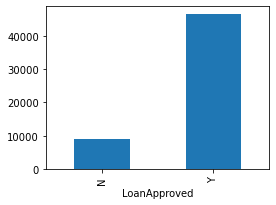

In [88]:
# Proveravamo raspodelu ciljne promenljive
GroupedData = Loan_df.groupby('LoanApproved').size()
GroupedData.plot(kind = 'bar', figsize = (4,3))

# Osnovna analiza podataka

In [89]:
# Proanalizirajmo sumirane informacije o podacima
Loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55382 entries, 0 to 55381
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              55382 non-null  int64  
 1   LoanID                  55382 non-null  int64  
 2   ApplicantID             55382 non-null  int64  
 3   ApplicantGender         54169 non-null  object 
 4   ApplicantMarried        55102 non-null  object 
 5   ApplicantDependents     53994 non-null  object 
 6   ApplicantEducation      55382 non-null  object 
 7   ApplicantSelfEmployed   52486 non-null  object 
 8   ApplicantIncome         55382 non-null  float64
 9   ApplicantCreditHistory  50900 non-null  float64
 10  ApplicantZIP            55382 non-null  object 
 11  ApplicantState          55382 non-null  object 
 12  ApplicantEmplLength     52729 non-null  object 
 13  ApplicantHomeOwn        55382 non-null  object 
 14  LoanAmount              53391 non-null

In [90]:
# Inicijalna statisticka analiza podataka
Loan_df.describe(include='all')

,Unnamed: 0,LoanID,ApplicantID,ApplicantGender,ApplicantMarried,ApplicantDependents,ApplicantEducation,ApplicantSelfEmployed,ApplicantIncome,ApplicantCreditHistory,ApplicantZIP,ApplicantState,ApplicantEmplLength,ApplicantHomeOwn,LoanAmount,LoanTerm,LoanIntRate,LoanDesc,LoanPurpose,LoanApproved
count,55382.000000,55382.000000,55382.000000,54169,55102,53994,55382,52486,55382.000000,50900.000000,55382,55382,52729,55382,53391.000000,54069.000000,55382,2180,21317,55382
unique,NaN,NaN,NaN,2,2,4,2,2,NaN,NaN,44,5,11,3,NaN,NaN,65,1552,9,2
top,NaN,NaN,NaN,MoÅ¡ki,DA,0 oseb,Diplomiral,NE,NaN,NaN,33xx,SI,10+ let,STANOVANJSKI KREDIT,NaN,NaN,3.12%,IzPosojilojemalec je dodal na 03-17-14 > kons...,kartica,Y
freq,NaN,NaN,NaN,44098,35898,31309,43086,45157,NaN,NaN,4684,27695,18105,28152,NaN,NaN,2958,12,13036,46454
mean,34567.738652,34589.653154,34502.024322,NaN,NaN,NaN,NaN,NaN,1797.359196,0.842593,NaN,NaN,NaN,NaN,51076.787286,85.456694,NaN,NaN,NaN,NaN
std,19957.683269,19936.557313,19958.352746,NaN,NaN,NaN,NaN,NaN,2006.631015,0.364187,NaN,NaN,NaN,NaN,29981.641674,16.227653,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,50.000000,0.000000,NaN,NaN,NaN,NaN,3150.000000,3.000000,NaN,NaN,NaN,NaN
25%,17253.250000,17366.250000,17216.500000,NaN,NaN,NaN,NaN,NaN,958.666667,1.000000,NaN,NaN,NaN,NaN,35000.000000,90.000000,NaN,NaN,NaN,NaN
50%,34567.500000,34542.500000,34444.000000,NaN,NaN,NaN,NaN,NaN,1270.666667,1.000000,NaN,NaN,NaN,NaN,44450.000000,90.000000,NaN,NaN,NaN,NaN
75%,51871.750000,51820.750000,51774.500000,NaN,NaN,NaN,NaN,NaN,1933.333333,1.000000,NaN,NaN,NaN,NaN,58100.000000,90.000000,NaN,NaN,NaN,NaN


In [91]:
# Jedinstvene vrednosti svake kolone 
Loan_df.nunique()

Unnamed: 0                55382
LoanID                    55382
ApplicantID               55382
ApplicantGender               2
ApplicantMarried              2
ApplicantDependents           4
ApplicantEducation            2
ApplicantSelfEmployed         2
ApplicantIncome             505
ApplicantCreditHistory        2
ApplicantZIP                 44
ApplicantState                5
ApplicantEmplLength          11
ApplicantHomeOwn              3
LoanAmount                  203
LoanTerm                     10
LoanIntRate                  65
LoanDesc                   1552
LoanPurpose                   9
LoanApproved                  2
dtype: int64

Based on the basic exploration above, we can now create a simple report of the data.
Na osnovu prethodne inicijalne analize mozemo kreirati prve zakljucke i vec odbaciti par atributa

- Unnamed: 0 Odbacena. Nece uticati na model. 
- LoanID: Odbacena. Nece uticati na model.
- ApplicantID: Odbacena. Nece uticati na model.
- ApplicantGender: Kategoricka. Neophodna dopuna podataka koji nedostaju.
- ApplicantMarried: Kategoricka. Neophodna dopuna podataka koji nedostaju.
- ApplicantDependents: Kategoricka. Neophodna dopuna podataka koji nedostaju.
- ApplicantEducation: Kategoricka.
- ApplicantSelfEmployed: Kategoricka. Neophodna dopuna podataka koji nedostaju.
- ApplicantIncome: Kvantitativna.
- ApplicantCreditHistory: Kategoricka. Neophodna dopuna podataka koji nedostaju.
- ApplicantZIP: Odbacena. Nece uticati na model.
- ApplicantState: Odbacena. Svi kandidati su iz Slovenije.
- ApplicantEmplLength: Kategoricka. Neophodna dopuna podataka koji nedostaju.
- ApplicantHomeOwn: Kategoricka.
- LoanAmount: Kvantitativna. Neophodna dopuna podataka koji nedostaju.
- LoanTerm: Kategoricka. Neophodna dopuna podataka koji nedostaju.
- LoanIntRate: Kvantitativna.
- LoanDesc:  Odbacena. Vise od 30% podataka nedostaje.
- LoanPurpose:  Odbacena. Vise od 30% podataka nedostaje.
- LoanApproved: Ciljna promenljiva.

### Uklanjanje odbacenih atributa

In [92]:
UselessColumns = ['Unnamed: 0', 'LoanID', 'ApplicantID', 'ApplicantZIP', 'ApplicantState', 'LoanDesc', 'LoanPurpose']
Loan_df = Loan_df.drop(UselessColumns, axis=1)
Loan_df.head()

,ApplicantGender,ApplicantMarried,ApplicantDependents,ApplicantEducation,ApplicantSelfEmployed,ApplicantIncome,ApplicantCreditHistory,ApplicantEmplLength,ApplicantHomeOwn,LoanAmount,LoanTerm,LoanIntRate,LoanApproved
0,MoÅ¡ki,NE,0 oseb,Diplomiral,NE,1949.666667,1.0,5 let,STANOVANJSKI KREDIT,NaN,90.0,1.42%,Y
1,MoÅ¡ki,DA,1 oseba,Diplomiral,NE,1527.666667,1.0,10+ let,NAJEM,44800.0,90.0,3.9%,N
2,MoÅ¡ki,DA,0 oseb,Diplomiral,DA,1000.000000,1.0,2 leti,STANOVANJSKI KREDIT,23100.0,90.0,3.26%,Y
3,MoÅ¡ki,DA,0 oseb,Brez diplome,NE,861.000000,1.0,3 leta,NAJEM,42000.0,90.0,2.8%,Y
4,MoÅ¡ki,NE,0 oseb,Diplomiral,NE,2000.000000,1.0,< 1 leto,STANOVANJSKI KREDIT,49350.0,90.0,2.9%,Y


# Vizuelna analiza podataka

In [93]:
# Crtamo kategoricke promenljive uz pomoc bar chart-a

def PlotBarCharts(df, colsToPlot):
        
    fig, subPlot = plt.subplots(nrows = 1, ncols = len(colsToPlot), figsize = (40,6))
    fig.suptitle('Bar charts of: '+ str(colsToPlot))

    for colName, plotNumber in zip(colsToPlot, range(len(colsToPlot))):
        df.groupby(colName).size().plot(kind = 'bar',ax = subPlot[plotNumber])


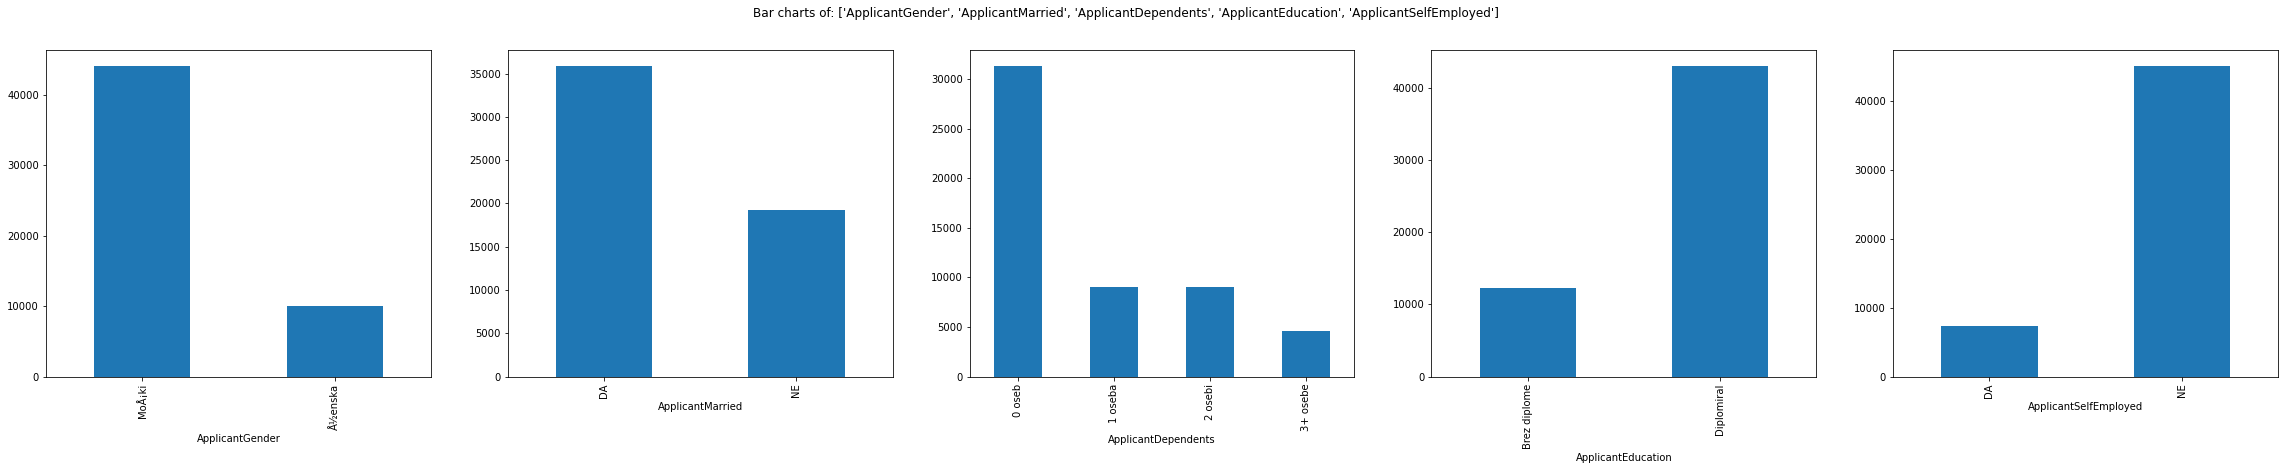

In [94]:
PlotBarCharts(df = Loan_df, colsToPlot=['ApplicantGender', 'ApplicantMarried', 'ApplicantDependents', 
                                         'ApplicantEducation', 'ApplicantSelfEmployed'])

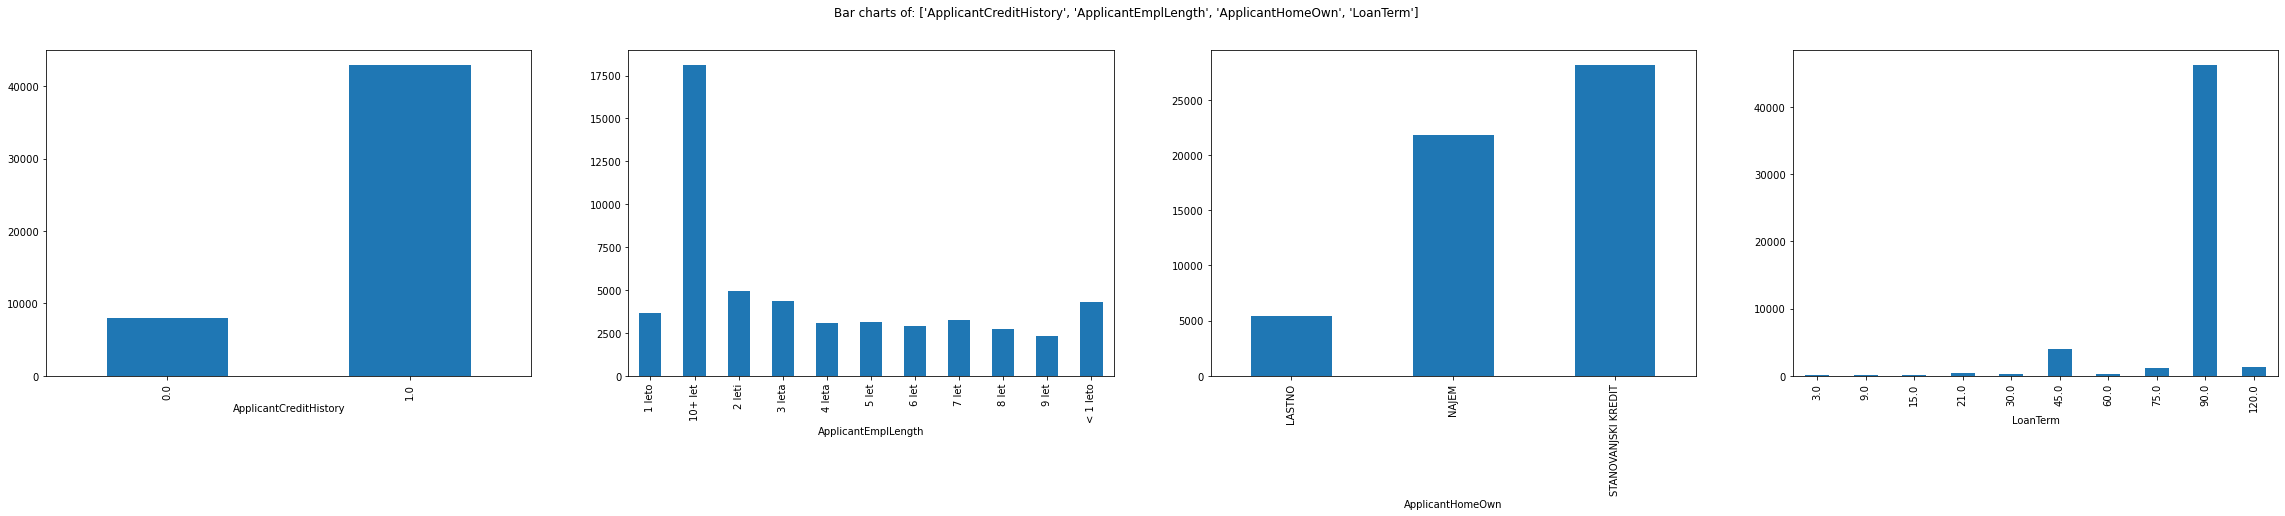

In [95]:
PlotBarCharts(df = Loan_df, colsToPlot=['ApplicantCreditHistory', 'ApplicantEmplLength', 'ApplicantHomeOwn', 'LoanTerm' ])

array([[<AxesSubplot:title={'center':'ApplicantIncome'}>,
        <AxesSubplot:title={'center':'LoanAmount'}>]], dtype=object)

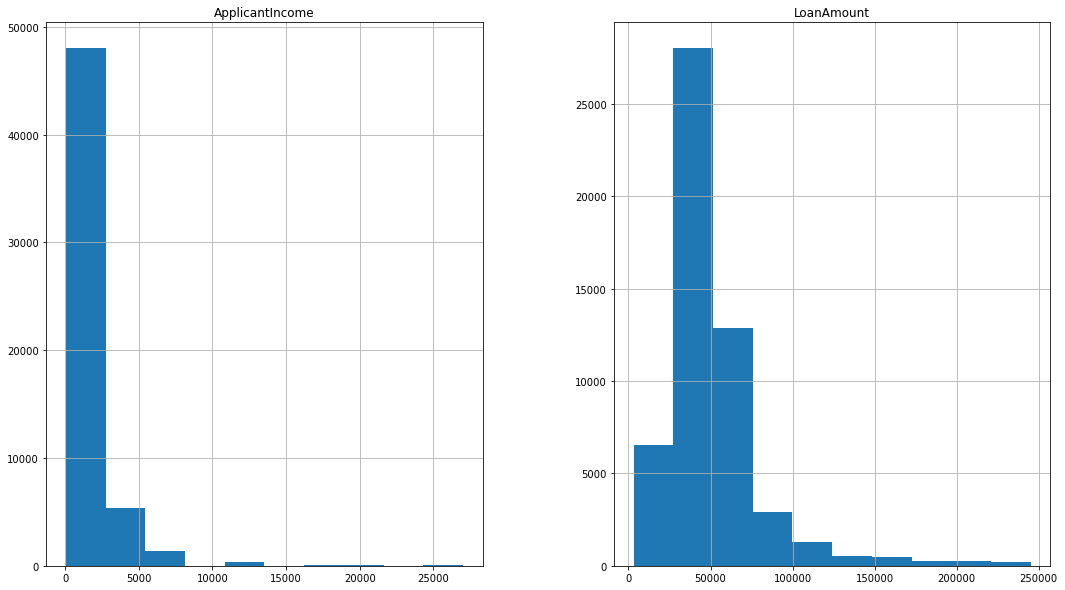

In [96]:
# Za kvantitativne promenljive crtamo histograme
# Primeticemo da ApplicantIncome ima autlajere
Loan_df.hist(['ApplicantIncome','LoanAmount'], figsize=(18,10))

# Tretman autlajera

In [97]:
Loan_df['ApplicantIncome'][Loan_df['ApplicantIncome']>8000].sort_values()

40175    11282.0
22007    11282.0
22533    11282.0
5324     11282.0
15476    11282.0
          ...   
18867    27000.0
19065    27000.0
19699    27000.0
44654    27000.0
25236    27000.0
Name: ApplicantIncome, Length: 616, dtype: float64

In [98]:
# Odbacivanjem kandidata sa zaradom vecom od 8000 odbacili bismo 1.1% uzorka
616/55382*100

1.1122747463074645

In [99]:
# Bez gubitka opstosti autlajerima cemo dodeliti platu od 8000
Loan_df['ApplicantIncome'][Loan_df['ApplicantIncome']>8000] = 8000

array([[<AxesSubplot:title={'center':'ApplicantIncome'}>]], dtype=object)

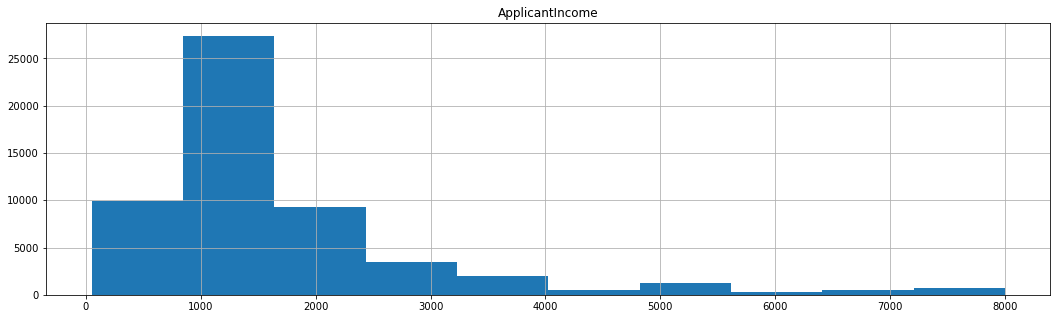

In [100]:
Loan_df.hist(['ApplicantIncome'], figsize=(18,5))

# Dopunjavanje podataka

In [101]:
Loan_df.isnull().sum()

ApplicantGender           1213
ApplicantMarried           280
ApplicantDependents       1388
ApplicantEducation           0
ApplicantSelfEmployed     2896
ApplicantIncome              0
ApplicantCreditHistory    4482
ApplicantEmplLength       2653
ApplicantHomeOwn             0
LoanAmount                1991
LoanTerm                  1313
LoanIntRate                  0
LoanApproved                 0
dtype: int64

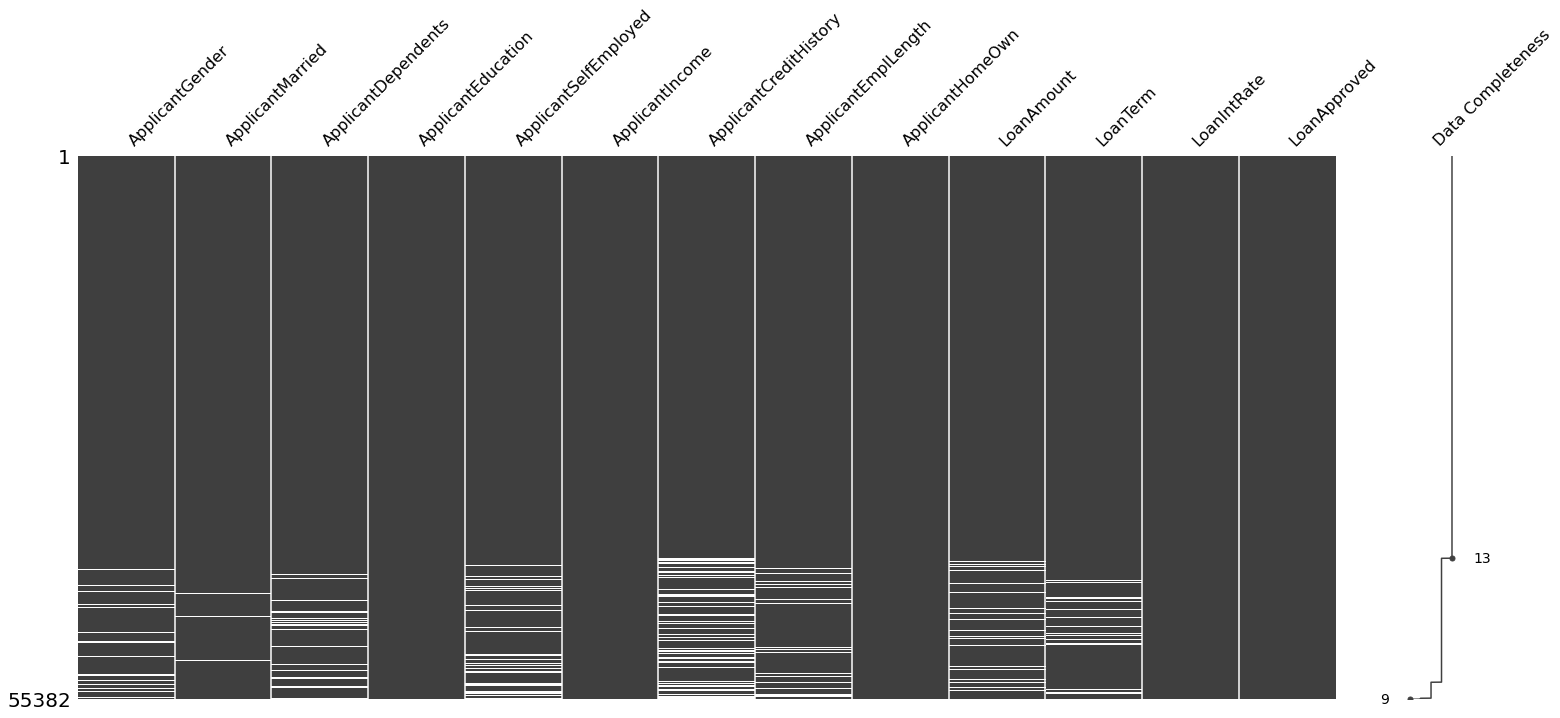

In [102]:
msno.matrix(Loan_df, labels=True, sort="descending");

#### Najvise podataka nedostaje za 'ApplicantCreditHistory' i to 8% od totala 55382.
#### Postoje razliciti nacini za dopunu podataka, za nas projekat koristicemo madijanu i modu dostupnih vrednosti.

In [103]:
# Koristimo modu za kategoricke atribute
Loan_df['ApplicantGender'].fillna(Loan_df['ApplicantGender'].mode()[0], inplace=True)
Loan_df['ApplicantMarried'].fillna(Loan_df['ApplicantMarried'].mode()[0], inplace=True)
Loan_df['ApplicantDependents'].fillna(Loan_df['ApplicantDependents'].mode()[0], inplace=True)
Loan_df['ApplicantSelfEmployed'].fillna(Loan_df['ApplicantSelfEmployed'].mode()[0], inplace=True)
Loan_df['ApplicantCreditHistory'].fillna(Loan_df['ApplicantCreditHistory'].mode()[0], inplace=True)
Loan_df['ApplicantEmplLength'].fillna(Loan_df['ApplicantEmplLength'].mode()[0], inplace=True)
Loan_df['LoanTerm'].fillna(Loan_df['LoanTerm'].mode()[0], inplace=True)

# Koristimo medijanu za neprekidne promenljive
Loan_df['LoanAmount'].fillna(Loan_df['LoanAmount'].median(), inplace=True)

In [104]:
Loan_df.isnull().sum()

ApplicantGender           0
ApplicantMarried          0
ApplicantDependents       0
ApplicantEducation        0
ApplicantSelfEmployed     0
ApplicantIncome           0
ApplicantCreditHistory    0
ApplicantEmplLength       0
ApplicantHomeOwn          0
LoanAmount                0
LoanTerm                  0
LoanIntRate               0
LoanApproved              0
dtype: int64

# Odabir atributa

- Vizualizacija odnosa neprekidnih atributa i ciljne promenljive
- Statisticka provera veze izmedju atributa

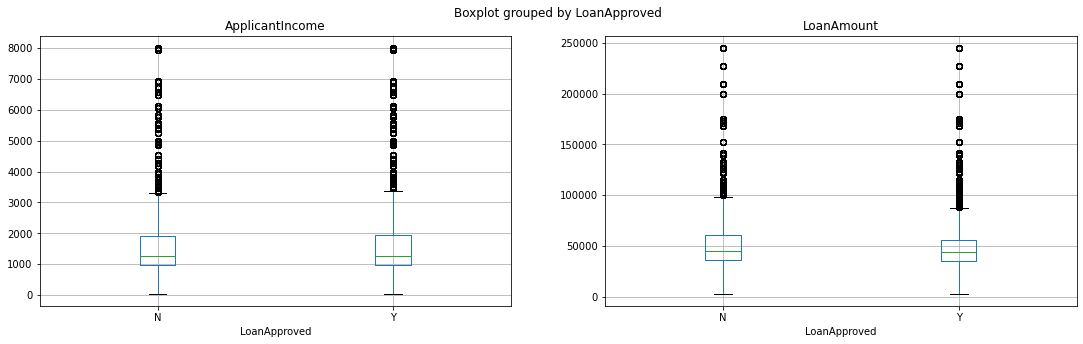

In [105]:
# Box plot za kategoricku ciljnu promenljivu i neprekidne atribute
ContinuousColsList=['ApplicantIncome', 'LoanAmount']

fig, PlotCanvas=plt.subplots(nrows=1, ncols=len(ContinuousColsList), figsize=(18,5))

# Pojedinacni box plotovi za svaku neprekidnu promenljivu
for PredictorCol , i in zip(ContinuousColsList, range(len(ContinuousColsList))):
    Loan_df.boxplot(column=PredictorCol, by='LoanApproved', figsize=(5,5), vert=True, ax=PlotCanvas[i])

# Statisticka provera veze izmedju atributa ANOVA testom

Analysis of variance(ANOVA) je test kojim statisticki potvrdjujemo vezu izmedju neprekidnih i kategorickih promenljivih.

- Hipoteza (H0): Ne postoji veza izmdju datih atributa 
- ANOVA Test rezultat: Verovatnoca da je H0 tacna

In [106]:
# Definismo funkciju za ANOVA test
def FunctionAnova(df, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Prazna lista gde cemo smestiti neprekidne atribute
    SelectedPredictors=[]
    
    print('ANOVA Rezultati')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=df.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # Ako je ANOVA p-vrednost <0.05, to ce znaciti da odbacujemo H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'je korelisan sa', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'nije korelisan sa', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [107]:
# Pozivamo funkciju
ContinuousVariables=['ApplicantIncome','LoanAmount']
FunctionAnova(df=Loan_df, TargetVariable='LoanApproved', ContinuousPredictorList=ContinuousVariables)

ANOVA Rezultati
ApplicantIncome je korelisan sa LoanApproved | P-Value: 0.021203297699540435
LoanAmount je korelisan sa LoanApproved | P-Value: 9.765723003353841e-73


['ApplicantIncome', 'LoanAmount']

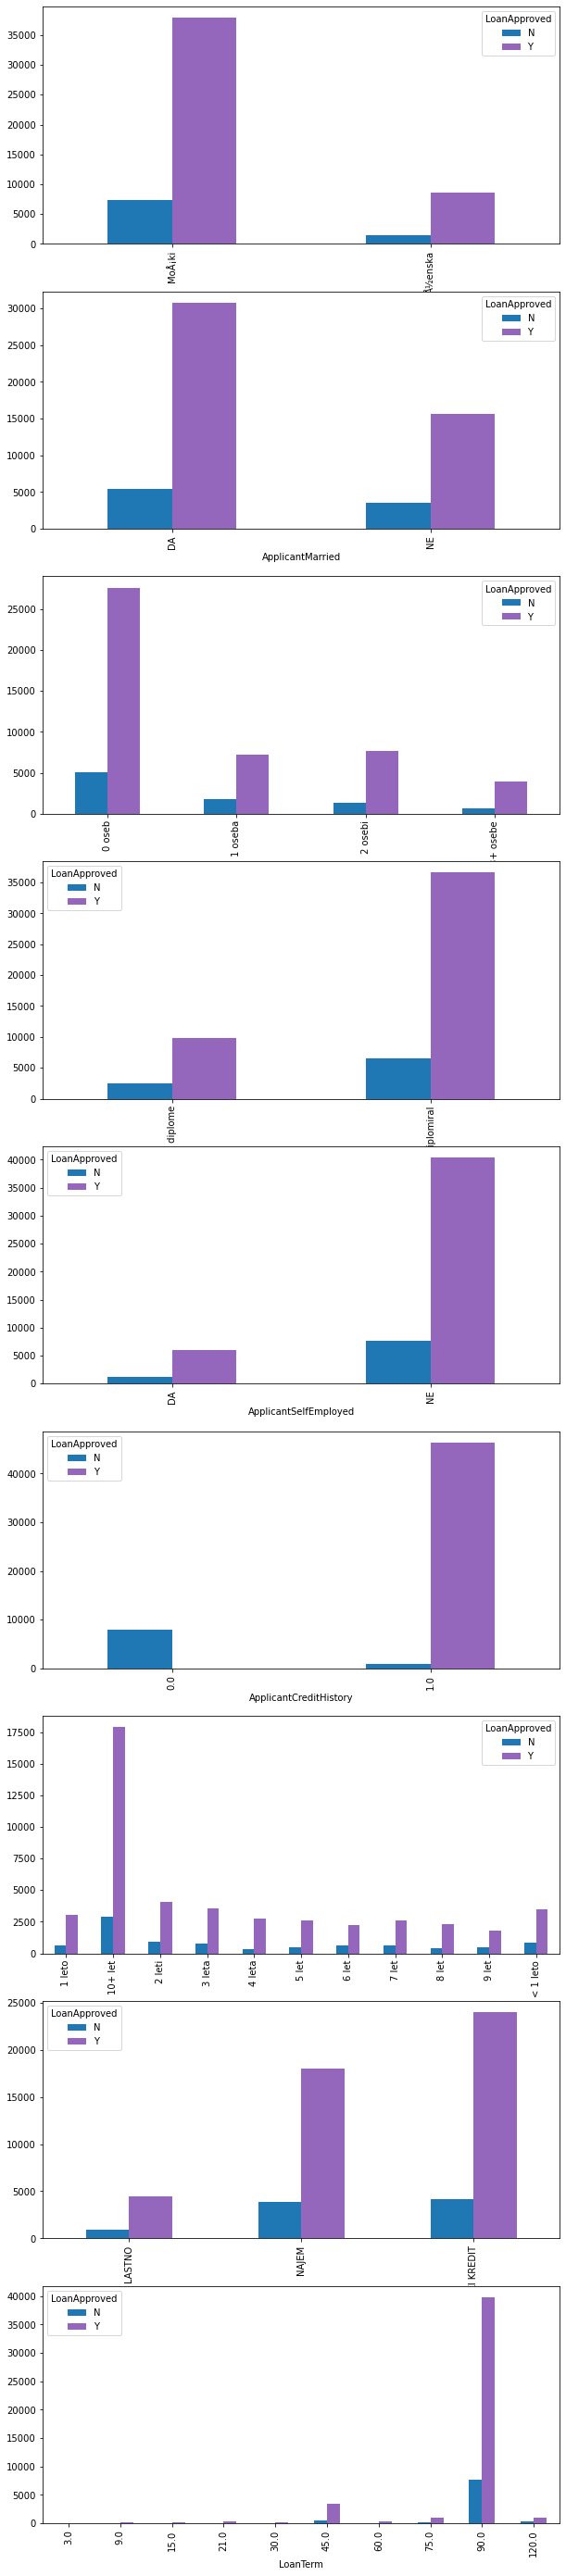

In [108]:
# Bar charts koristimo za odnos kategorickih atributa sa ciljnom promenljivom
CategoricalColsList=['ApplicantGender', 'ApplicantMarried', 'ApplicantDependents', 'ApplicantEducation', 
                     'ApplicantSelfEmployed', 'ApplicantCreditHistory', 'ApplicantEmplLength', 
                     'ApplicantHomeOwn', 'LoanTerm']


fig, PlotCanvas=plt.subplots(nrows=len(CategoricalColsList), ncols=1, figsize=(10,50))


for CategoricalCol , i in zip(CategoricalColsList, range(len(CategoricalColsList))):
    CrossTabResult=pd.crosstab(index=Loan_df[CategoricalCol], columns=Loan_df['LoanApproved'])
    CrossTabResult.plot.bar(color=['#1f77b4', '#9467bd'], ax=PlotCanvas[i])

In [109]:
SelectedColumns=['ApplicantMarried', 'ApplicantEducation',  'ApplicantSelfEmployed', 'ApplicantDependents',
                 'ApplicantCreditHistory', 'ApplicantHomeOwn', 'ApplicantIncome','LoanAmount']

# Finalni atributi za modeliranje
Data_ML=Loan_df[SelectedColumns]
Data_ML.head()

,ApplicantMarried,ApplicantEducation,ApplicantSelfEmployed,ApplicantDependents,ApplicantCreditHistory,ApplicantHomeOwn,ApplicantIncome,LoanAmount
0,NE,Diplomiral,NE,0 oseb,1.0,STANOVANJSKI KREDIT,1949.666667,44450.0
1,DA,Diplomiral,NE,1 oseba,1.0,NAJEM,1527.666667,44800.0
2,DA,Diplomiral,DA,0 oseb,1.0,STANOVANJSKI KREDIT,1000.000000,23100.0
3,DA,Brez diplome,NE,0 oseb,1.0,NAJEM,861.000000,42000.0
4,NE,Diplomiral,NE,0 oseb,1.0,STANOVANJSKI KREDIT,2000.000000,49350.0


# Priprema podataka za treniranje modela

## Pretvaranje binarne nominalne varijable u numericku pomocu 1/0 preslikavanja

In [111]:
Data_ML['ApplicantMarried'] = Data_ML.ApplicantMarried.astype(object)
Data_ML['ApplicantEducation'] = Data_ML.ApplicantEducation.astype(object)
Data_ML['ApplicantSelfEmployed'] = Data_ML.ApplicantSelfEmployed.astype(object)
Data_ML['ApplicantCreditHistory'] = Data_ML.ApplicantCreditHistory.astype(object)

In [112]:
Data_ML['ApplicantMarried'].replace({'DA':1, 'NE':0}, inplace=True)
Data_ML['ApplicantEducation'].replace({'Diplomiral':1, 'Brez diplome':0}, inplace=True)
Data_ML['ApplicantSelfEmployed'].replace({'DA':1, 'NE':0}, inplace=True)
Data_ML['ApplicantCreditHistory'].replace({'1.0':1, '0.0':0}, inplace=True)

# Provera podataka nakon 1/0 mapiranja
Data_ML.head()

,ApplicantMarried,ApplicantEducation,ApplicantSelfEmployed,ApplicantDependents,ApplicantCreditHistory,ApplicantHomeOwn,ApplicantIncome,LoanAmount
0,0,1,0,0 oseb,1.0,STANOVANJSKI KREDIT,1949.666667,44450.0
1,1,1,0,1 oseba,1.0,NAJEM,1527.666667,44800.0
2,1,1,1,0 oseb,1.0,STANOVANJSKI KREDIT,1000.000000,23100.0
3,1,0,0,0 oseb,1.0,NAJEM,861.000000,42000.0
4,0,1,0,0 oseb,1.0,STANOVANJSKI KREDIT,2000.000000,49350.0


## Pretvaranje nominalne varijable u numericku pomocu get_dummies() funkcije

In [113]:
# Sve nominalne varijable transformisemo u numericke pomocu get_dummies() funkcije
Data_ML_Numeric=pd.get_dummies(Data_ML)

# Dodajemo i ciljnu promanljivu
Data_ML_Numeric['LoanApproved']=Loan_df['LoanApproved']
Data_ML_Numeric['LoanApproved'].replace({'Y':1, 'N':0}, inplace=True)

# DataFrame sa finalnim atributima za model
Data_ML_Numeric.head()

,ApplicantMarried,ApplicantEducation,ApplicantSelfEmployed,ApplicantCreditHistory,ApplicantIncome,LoanAmount,ApplicantDependents_0 oseb,ApplicantDependents_1 oseba,ApplicantDependents_2 osebi,ApplicantDependents_3+ osebe,ApplicantHomeOwn_LASTNO,ApplicantHomeOwn_NAJEM,ApplicantHomeOwn_STANOVANJSKI KREDIT,LoanApproved
0,0,1,0,1.0,1949.666667,44450.0,1,0,0,0,0,0,1,1
1,1,1,0,1.0,1527.666667,44800.0,0,1,0,0,0,1,0,0
2,1,1,1,1.0,1000.000000,23100.0,1,0,0,0,0,0,1,1
3,1,0,0,1.0,861.000000,42000.0,1,0,0,0,0,1,0,1
4,0,1,0,1.0,2000.000000,49350.0,1,0,0,0,0,0,1,1


# Podela podataka za treniranje i testiranje

In [114]:
Data_ML_Numeric.columns

Index(['ApplicantMarried', 'ApplicantEducation', 'ApplicantSelfEmployed',
       'ApplicantCreditHistory', 'ApplicantIncome', 'LoanAmount',
       'ApplicantDependents_0 oseb', 'ApplicantDependents_1 oseba',
       'ApplicantDependents_2 osebi', 'ApplicantDependents_3+ osebe',
       'ApplicantHomeOwn_LASTNO', 'ApplicantHomeOwn_NAJEM',
       'ApplicantHomeOwn_STANOVANJSKI KREDIT', 'LoanApproved'],
      dtype='object')

In [115]:
# Delimo atribute od ciljne promanljive
TargetVariable='LoanApproved'
Predictors=['ApplicantMarried', 'ApplicantEducation', 'ApplicantSelfEmployed',
       'ApplicantCreditHistory', 'ApplicantIncome', 'LoanAmount', 'ApplicantDependents_0 oseb', 'ApplicantDependents_1 oseba',
       'ApplicantDependents_2 osebi', 'ApplicantDependents_3+ osebe', 'ApplicantHomeOwn_LASTNO',
       'ApplicantHomeOwn_NAJEM', 'ApplicantHomeOwn_STANOVANJSKI KREDIT']

X=Data_ML_Numeric[Predictors].values
y=Data_ML_Numeric[TargetVariable].values


In [116]:
# Obzirom da ce se u radu fokusiram na poredjenje razlicitih tipova modela, podatke delim na skupove za trening i test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

# Sandardizacija

In [117]:
# Sandardizacija podataka
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [118]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(38767, 13)
(38767,)
(16615, 13)
(16615,)


# Logisticka Regresija

In [119]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(C=1,penalty='l2', solver='newton-cg')

# Prikazujemo sve parametre
print(clf1)

# Kreiramo model na trening podacima 
LOG=clf1.fit(X_train,y_train)
prediction=LOG.predict(X_test)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


In [120]:
# Proveravamo preciznost modela na test podacima
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Preciznost modela na testnom skupu podataka:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2678
           1       0.98      1.00      0.99     13937

    accuracy                           0.98     16615
   macro avg       0.98      0.96      0.97     16615
weighted avg       0.98      0.98      0.98     16615

[[ 2454   224]
 [   63 13874]]
Preciznost modela na testnom skupu podataka: 0.98


In [121]:
# Unakrsna validacija
from sklearn.model_selection import cross_val_score
Accuracy_Values=cross_val_score(LOG, X , y, cv=10, scoring='f1_weighted')
print('\nPreciznost modela za 10-fold unakrsnu validaciju:\n',Accuracy_Values)
print('\nFinalna prosecna preciznost modela:', round(Accuracy_Values.mean(),2))


Preciznost modela za 10-fold unakrsnu validaciju:
 [0.97126942 0.98359248 0.98481836 0.98630806 0.98281081 0.98557805
 0.98298133 0.98390021 0.98536383 0.98685909]

Finalna prosecna preciznost modela: 0.98


# Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(max_depth=2, n_estimators=100,criterion='gini')

# Prikazujemo sve parametre
print(clf2)

# Kreiramo model na trening podacima
RF=clf2.fit(X_train,y_train)
prediction=RF.predict(X_test)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [124]:
# Proveravamo preciznost modela na test podacima
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Preciznost modela na testnom skupu podataka:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      2678
           1       0.95      1.00      0.97     13937

    accuracy                           0.95     16615
   macro avg       0.97      0.85      0.90     16615
weighted avg       0.95      0.95      0.95     16615

[[ 1898   780]
 [   20 13917]]
Preciznost modela na testnom skupu podataka: 0.95


In [125]:
# Unakrsna validacija
from sklearn.model_selection import cross_val_score
Accuracy_Values=cross_val_score(RF, X , y, cv=10, scoring='f1_weighted')
print('\nPreciznost modela za 10-fold unakrsnu validaciju:\n',Accuracy_Values)
print('\nFinalna prosecna preciznost modela:', round(Accuracy_Values.mean(),2))


Preciznost modela za 10-fold unakrsnu validaciju:
 [0.86712053 0.77590112 0.98155918 0.77233134 0.98041377 0.95144874
 0.77292318 0.95577523 0.78766512 0.98472902]

Finalna prosecna preciznost modela: 0.88


<AxesSubplot:>

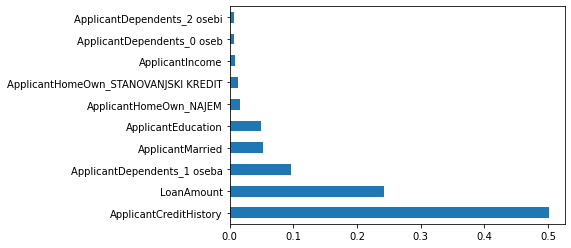

In [126]:
# Prikaz tezine atributa u modelu
%matplotlib inline
feature_importances = pd.Series(RF.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

# AdaBoost

In [127]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(max_depth=1)
clf2 = AdaBoostClassifier(n_estimators=500, base_estimator=DTC ,learning_rate=0.01)

# Prikazujemo sve parametre
print(clf2)

# Kreiramo model na trening podacima
AB=clf2.fit(X_train,y_train)
prediction=AB.predict(X_test)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [128]:
# Proveravamo preciznost modela na test podacima
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Preciznost modela na testnom skupu podataka:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2678
           1       0.98      1.00      0.99     13937

    accuracy                           0.98     16615
   macro avg       0.99      0.94      0.96     16615
weighted avg       0.98      0.98      0.98     16615

[[ 2387   291]
 [   22 13915]]
Preciznost modela na testnom skupu podataka: 0.98


In [129]:
# Unakrsna validacija
from sklearn.model_selection import cross_val_score
Accuracy_Values=cross_val_score(AB, X , y, cv=10, scoring='f1_weighted')
print('\nPreciznost modela za 10-fold unakrsnu validaciju:\n',Accuracy_Values)
print('\nFinalna prosecna preciznost modela:', round(Accuracy_Values.mean(),2))



Preciznost modela za 10-fold unakrsnu validaciju:
 [0.96778802 0.98156306 0.98155918 0.98306844 0.98098256 0.98229736
 0.98210846 0.98268356 0.98288061 0.9851044 ]

Finalna prosecna preciznost modela: 0.98


<AxesSubplot:>

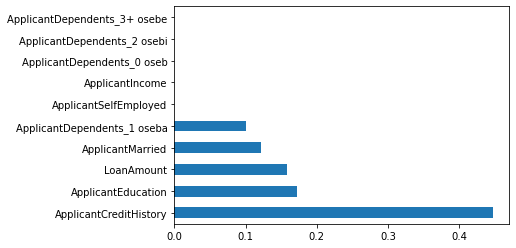

In [130]:
# Prikaz tezine atributa u modelu
%matplotlib inline
feature_importances = pd.Series(AB.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

# XGBoost

In [131]:
from xgboost import XGBClassifier
clf3=XGBClassifier(max_depth=2, learning_rate=0.01, n_estimators=200, objective='binary:logistic', booster='gbtree')

# Prikazujemo sve parametre
print(clf3)

# Kreiramo model na trening podacima
XGB=clf3.fit(X_train,y_train)
prediction=XGB.predict(X_test)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              predictor=None, random_state=None, reg_alpha=None, ...)


In [132]:
# Proveravamo preciznost modela na test podacima
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Preciznost modela na testnom skupu podataka:', round(F1_Score,2))


              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2678
           1       0.98      1.00      0.99     13937

    accuracy                           0.98     16615
   macro avg       0.99      0.94      0.96     16615
weighted avg       0.98      0.98      0.98     16615

[[ 2387   291]
 [   22 13915]]
Preciznost modela na testnom skupu podataka: 0.98


In [133]:
# Unakrsna validacija
from sklearn.model_selection import cross_val_score
Accuracy_Values=cross_val_score(XGB, X , y, cv=10, scoring='f1_weighted')
print('\nPreciznost modela za 10-fold unakrsnu validaciju:\n',Accuracy_Values)
print('\nFinalna prosecna preciznost modela:', round(Accuracy_Values.mean(),2))


Preciznost modela za 10-fold unakrsnu validaciju:
 [0.96778802 0.98156306 0.98155918 0.98306844 0.98098256 0.98229736
 0.98210846 0.98268356 0.98288061 0.9851044 ]

Finalna prosecna preciznost modela: 0.98


<AxesSubplot:>

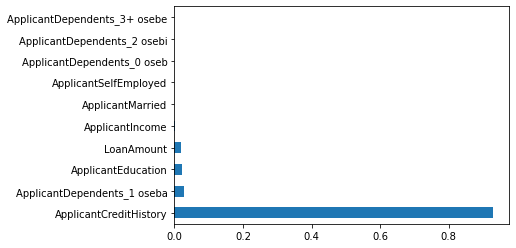

In [134]:
# Prikaz tezine atributa u modelu
%matplotlib inline
feature_importances = pd.Series(XGB.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')